<h1><center>Fast Food Marketing Campaign</center></h1>
<center>May 2024</center>
<center>Celine Ng</center>

<a id="0"></a> <br>
# Table of Contents

1. [Project Introduction](#1)     
    1. [Libraries Installation](#2) 
    1. [Data Retrieval](#3)
    1. [Data Cleaning](#4)
1. [EDA](#5) 
    1. [Quick Visualization](#6)
        1. [Summary](#7)
1. [Assumption Checking](#7) 
1. [Create a Validation Set](#4)     
    1. [Remove target column](#5) 
1. [Feature Scaling](#6)     
1. [First Model](#8)     
    1. [Evaluation Metrics for Training set](#9)     
    1. [Evaluation Metrics for Validation set](#10)     
    1. [First Submission](#11) 
1. [Selecting Models](#12)       
    1. [Helper Functions to Try New Models](#13)      
    1. [Split to the Small Data for Evaluating Models Fast](#14)     
    1. [ML Models](#15)         
        1. [XGBoost](#16)             
            1. [Training](#17)


<a id="1"></a> <br>
# 1. Project Introduction

### Goal
The fast-food chain tested out 3 promotions in several store and <br>
the data records sales in the initial 4 weeks of the new promotion. <br>
Apply A/B test to understand which of the 3 campaigns is the most effective.

<a id="2"></a> <br>
## 1.1 Libraries Installation

In [136]:
%%capture
%pip install -r requirements.txt

In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils.plotting import *

<a id="3"></a> <br>
## 1.2 Data Retrieval

In [11]:
fastfood = pd.read_csv('dataset/fast_food.csv')

In [12]:
fastfood.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


<a id="4"></a> <br>
## 1.3 Data Cleaning

1. Check for missing values

In [14]:
fastfood.isna().any().any()

False

2. Check for duplicates 

In [16]:
fastfood.duplicated().any()

False

<a id="5"></a> <br>
# 2. EDA

<a id="6"></a> <br>
## 2.1 Quick Visualization

Objective:
Briefly understand our data and its distribution

1. Rows and columns of our dataset

In [17]:
fastfood.shape

(548, 7)

2. Dataset descriptive statistics overview

In [18]:
fastfood.describe()

,MarketID,LocationID,AgeOfStore,Promotion,week,SalesInThousands
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,5.715328,479.656934,8.503650,2.029197,2.500000,53.466204
std,2.877001,287.973679,6.638345,0.810729,1.119055,16.755216
min,1.000000,1.000000,1.000000,1.000000,1.000000,17.340000
25%,3.000000,216.000000,4.000000,1.000000,1.750000,42.545000
50%,6.000000,504.000000,7.000000,2.000000,2.500000,50.200000
75%,8.000000,708.000000,12.000000,3.000000,3.250000,60.477500
max,10.000000,920.000000,28.000000,3.000000,4.000000,99.650000


3. How many MarketID and LocationID?

In [21]:
fastfood['MarketID'].nunique()

10

In [23]:
fastfood['LocationID'].nunique()

137

4. Visualize dataset features

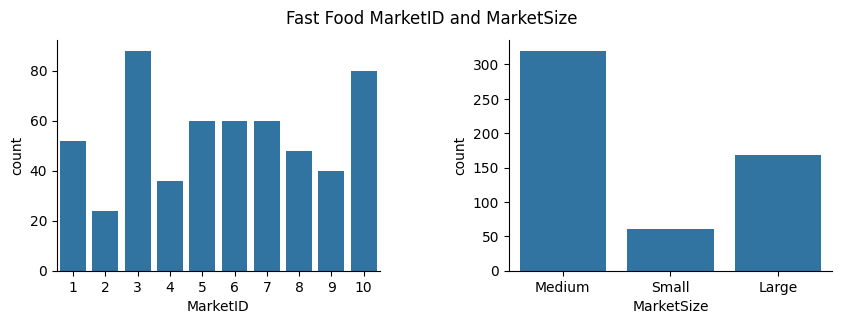

In [103]:
columns_to_plot = [col for col in fastfood.columns if col in ['MarketID', 
                                                              'MarketSize']]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
fig.subplots_adjust(hspace=0.3, wspace=0.4)

for i, col in enumerate(columns_to_plot):
    sns.countplot(x=col, data=fastfood, ax=ax[i])

sns.despine(top=True, right=True, left=False, bottom=False)

fig.suptitle('Fast Food MarketID and MarketSize')

plt.show()

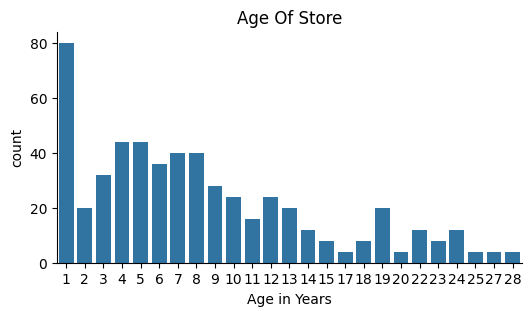

In [100]:
plt.figure(figsize=(6, 3))
sns.countplot(x='AgeOfStore', data=fastfood)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xlabel('Age in Years')
plt.title('Age Of Store')
plt.show()

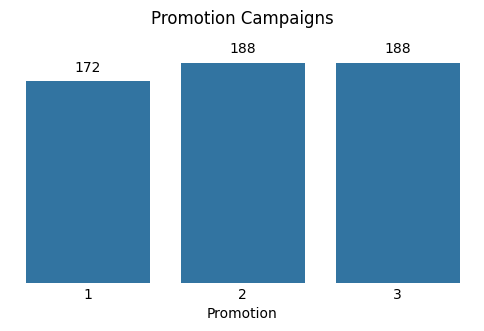

In [87]:
plt.figure(figsize=(6, 3))
ax = sns.countplot(x='Promotion', data=fastfood)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p
                                           .get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset'
                                                                     ' points')
    
sns.despine(top=True, right=True, left=True, bottom=True)
ax.tick_params(axis='x', which='both', length=0, labelbottom=True)
ax.tick_params(axis='y', which='both', length=0, labelleft=False)
ax.set(ylabel=None)

plt.title('Promotion Campaigns', pad=20)
plt.show()

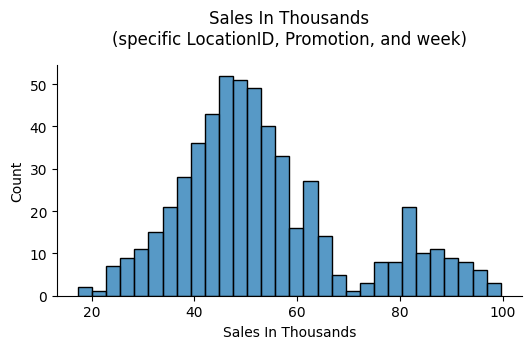

In [102]:
plt.figure(figsize=(6, 3))
sns.histplot(data=fastfood, x='SalesInThousands', bins=30, kde_kws={'shade':
                                                                        True})
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xlabel('Sales In Thousands')
plt.title('Sales In Thousands\n(specific LocationID, Promotion, and week)', 
          pad=15)
plt.show()

<a id="7"></a> <br>
## 2.1.1 Summary

Our dataset is composed by sales data of the 3 promotions, registered across
 <br>
10 unique markets and 137 store locations. <br>
Our sample shows that most markets are medium, with 50% of stores are less <br>
than 7 years old. Median sales are around 50 000 and all 3 promotion <br>
campaigns were tested similar amounts of times, with 172 for promotion 1 and
 <br>
 188 for promotions 2 and 3. <br>
 
*To note: Both SalesInThousands and AgeOfStore distributions seem to be <br>
bimodal, which likely indicate 2 different sub-populations in our data.*

<a id="8"></a> <br>
## 2.2 Separate by Promotion

Objective: 
To better define our target metric, it is essential to understand the 
features, and the relationship between them, specially with the 3 promotions.

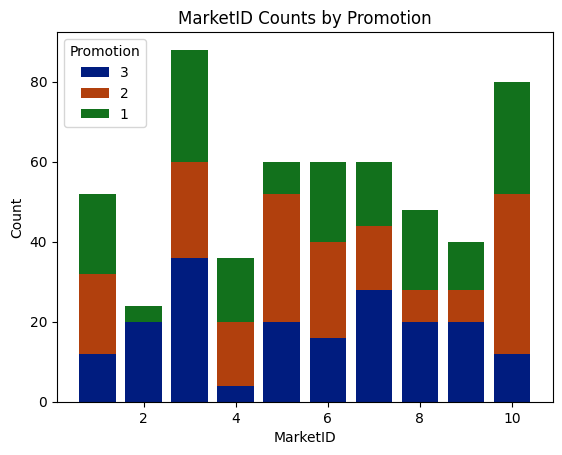

In [151]:
stacked_bar_plot(fastfood, col='MarketID', hue='Promotion')

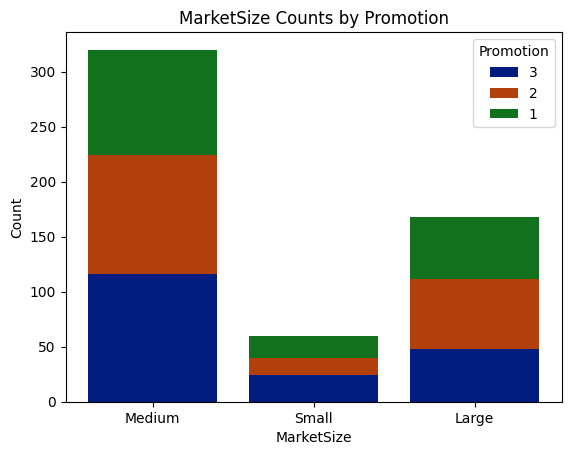

In [152]:
stacked_bar_plot(fastfood, col='MarketSize', hue='Promotion')

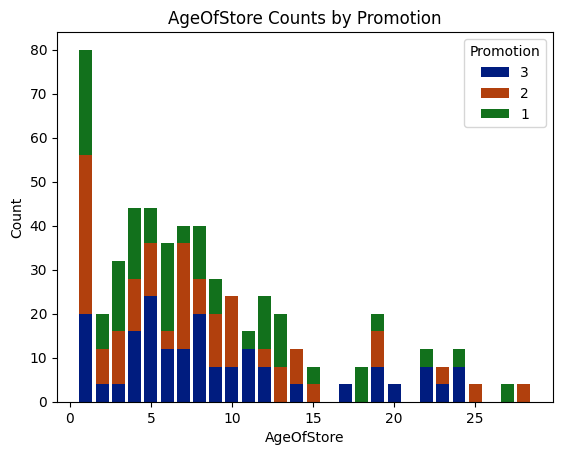

In [154]:
stacked_bar_plot(fastfood, col='AgeOfStore', hue='Promotion')

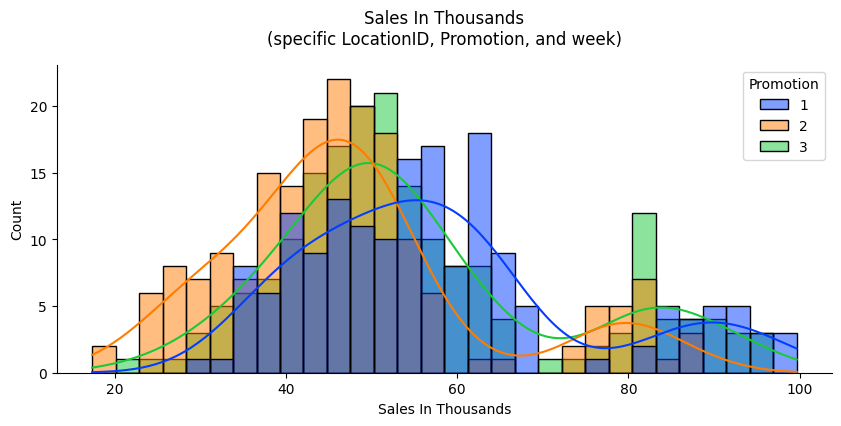

In [173]:
plt.figure(figsize=(10, 4))
sns.histplot(data=fastfood, x='SalesInThousands', hue='Promotion', bins=30,
             palette=sns.color_palette('bright', n_colors=3), kde=True)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xlabel('Sales In Thousands')
plt.title('Sales In Thousands\n(specific LocationID, Promotion, and week)', 
          pad=15)
plt.show()

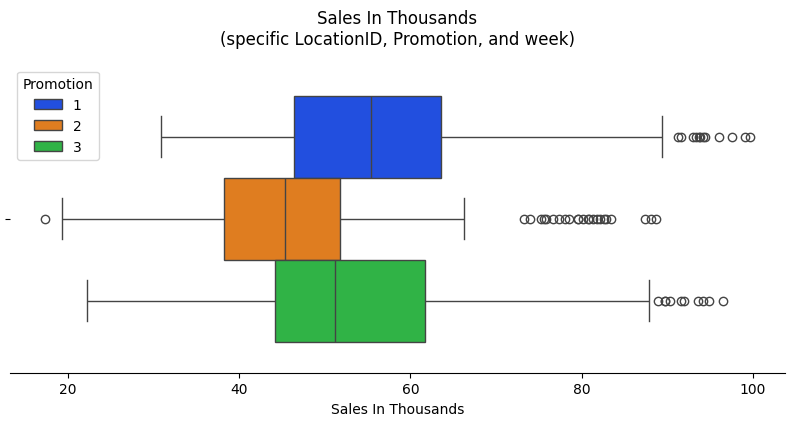

In [170]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=fastfood, x='SalesInThousands', hue='Promotion',
             palette=sns.color_palette('bright', n_colors=3))
sns.despine(top=True, right=True, left=True, bottom=False)
plt.xlabel('Sales In Thousands')
plt.title('Sales In Thousands\n(specific LocationID, Promotion, and week)', 
          pad=15)
plt.show()

<a id="7"></a> <br>
# 3. Assumptions Checking

Objective:
Simple random sample <br>
Large enough sample to approximate our sampling distribution with a normal <br>
curve (to use z multiplier...) <br>
define large enough as at least ten of each response outcomes <br>